# Intro

With some experimentation I found that VGG16 and VGG19 did not perform as well as Inception and XceptionV3 on the data. Therefore this kernel is about how to get the best out of the Xception and InceptionV3 pretrained weights using different ensembling methods.


In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

from keras.preprocessing.image import ImageDataGenerator
from keras.applications.xception import Xception
from keras.applications.inception_v3 import InceptionV3

from keras.applications.xception import preprocess_input as xception_preprocessor
from keras.applications.inception_v3 import preprocess_input as inception_v3_preprocessor

c:\users\popeye\appdata\local\programs\python\python35\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Data Exploration

If we look at the spread of frequencies of each class, the most common class has a frequency of almost double that of the least common class.

NB. So that the kernel does not timeout we will limit to just the top 16 classes, but for submission we will predict on all classes.

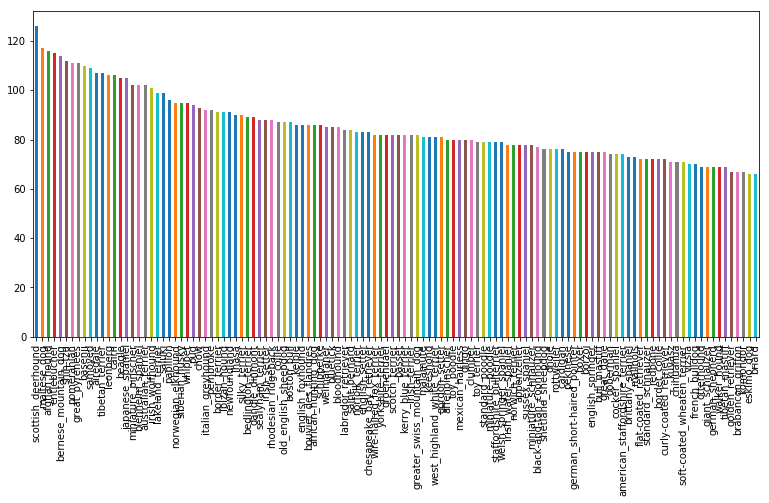

['affenpinscher', 'afghan_hound', 'african_hunting_dog', 'airedale', 'american_staffordshire_terrier', 'appenzeller', 'australian_terrier', 'basenji', 'basset', 'beagle', 'bedlington_terrier', 'bernese_mountain_dog', 'black-and-tan_coonhound', 'blenheim_spaniel', 'bloodhound', 'bluetick', 'border_collie', 'border_terrier', 'borzoi', 'boston_bull', 'bouvier_des_flandres', 'boxer', 'brabancon_griffon', 'briard', 'brittany_spaniel', 'bull_mastiff', 'cairn', 'cardigan', 'chesapeake_bay_retriever', 'chihuahua', 'chow', 'clumber', 'cocker_spaniel', 'collie', 'curly-coated_retriever', 'dandie_dinmont', 'dhole', 'dingo', 'doberman', 'english_foxhound', 'english_setter', 'english_springer', 'entlebucher', 'eskimo_dog', 'flat-coated_retriever', 'french_bulldog', 'german_shepherd', 'german_short-haired_pointer', 'giant_schnauzer', 'golden_retriever', 'gordon_setter', 'great_dane', 'great_pyrenees', 'greater_swiss_mountain_dog', 'groenendael', 'ibizan_hound', 'irish_setter', 'irish_terrier', 'iris

In [4]:
LABELS = "labels.csv"

train_df = pd.read_csv(LABELS)
#return top 16 value counts and convert into list
plt.figure(figsize=(13, 6))
train_df['breed'].value_counts().plot(kind='bar')
plt.show()

top_breeds = sorted(list(train_df['breed'].value_counts().head(120).index))
train_df = train_df[train_df['breed'].isin(top_breeds)]

print(top_breeds)

# Train and Validation Split

We will load the images into an numpy array and split the data into train and  cross validation sets.

I've chosen to take a 80:20 split of the data for cross validation. Strictly speaking we don't need to stratify split the dataset but it will ensure that the training and cross validation set are balanced.

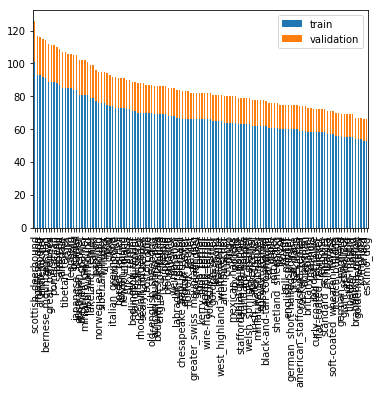

In [5]:
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
from sklearn.model_selection import train_test_split

SEED = 1234

TRAIN_FOLDER = "train/"
TEST_FOLDER = "test/"

DIM = 299

train_df['image_path'] = train_df.apply( lambda x: ( TRAIN_FOLDER + x["id"] + ".jpg" ), axis=1 )

train_data = np.array([ img_to_array(load_img(img, target_size=(DIM, DIM))) for img in train_df['image_path'].values.tolist()]).astype('float32')
train_labels = train_df['breed']


x_train, x_validation, y_train, y_validation = train_test_split(train_data, train_labels, test_size=0.2, stratify=np.array(train_labels), random_state=SEED)

#calculate the value counts for train and validation data
data = y_train.value_counts().sort_index().to_frame()
data.columns = ['train']
data['validation'] = y_validation.value_counts().sort_index().to_frame()

new_plot = data[['train','validation']].sort_values(['train']+['validation'], ascending=False)
new_plot.plot(kind='bar', stacked=True)
plt.show()

## One-hot Encoding

Since the output of our predictor for each input is a vector of probabilities for each class we must convert out label dataset to be the same format. That is for each input a row vector of length num_classes with a 1 at the index of the label and 0's everywhere else.

In [6]:
x_train.shape

(8177, 299, 299, 3)

In [7]:
# Let's convert our labels into one hot encoded format

y_train = pd.get_dummies(y_train.reset_index(drop=True), columns=top_breeds).as_matrix()
y_validation = pd.get_dummies(y_validation.reset_index(drop=True), columns=top_breeds).as_matrix()

print(y_train[0])

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 0 0]


c:\users\popeye\appdata\local\programs\python\python35\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until
c:\users\popeye\appdata\local\programs\python\python35\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.


Let's double check that our inputs and labels match.

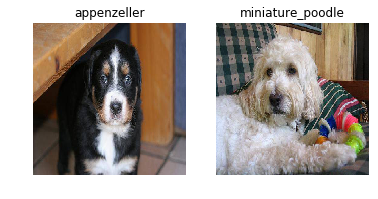

In [8]:
plt.subplot(1, 2, 1)
plt.title(top_breeds[np.where(y_train[5]==1)[0][0]])
plt.axis('off')
plt.imshow(x_train[5].astype(np.uint8))

plt.subplot(1, 2, 2)
plt.title(top_breeds[np.where(y_train[7]==1)[0][0]])
plt.axis('off')
plt.imshow(x_train[7].astype(np.uint8))
plt.show()

# Generate bottleneck features

Since kaggle kernels have no access to the internet we must use a pre-downloaded dataset and copy the files to the cache and models directory.

In [7]:
from os import makedirs
from os.path import expanduser, exists, join

# !ls ../input/keras-pretrained-models/

# cache_dir = expanduser(join('~', '.keras'))
# if not exists(cache_dir):
#     makedirs(cache_dir)
# models_dir = join(cache_dir, 'models')
# if not exists(models_dir):
#     makedirs(models_dir)
    
# !cp ../input/keras-pretrained-models/*notop* ~/.keras/models/
# !cp ../input/keras-pretrained-models/imagenet_class_index.json ~/.keras/models/
# !cp ../input/keras-pretrained-models/resnet50* ~/.keras/models/

Let's define a function that will output bottleneck features from a given model. 

We will use 'imagenet' weights and remove the final layers of the neural network so that we can use our own classifier.

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, accuracy_score

batch_size = 16
epochs = 30
num_classes = len(top_breeds)

def generate_features(model_info, data, labels, datagen):
    print("generating features...")
    datagen.preprocessing_function = model_info["preprocessor"]
    generator = datagen.flow(data, labels, shuffle=False, batch_size=batch_size, seed=model_info["seed"])
    bottleneck_model = model_info["model"](weights='imagenet', include_top=False, input_shape=model_info["input_shape"], pooling=model_info["pooling"])
    return bottleneck_model.predict_generator(generator)


## Define our models and run

First we define the settings for our models such as the input shape and the preprocessor which we will feed into generate_features.

Then let's generate our train features and validation features and save them to file so that we don't need to compute them again.

In [10]:
import time

models = {
    "InceptionV3": {
        "model": InceptionV3,
        "preprocessor": inception_v3_preprocessor,
        "input_shape": (299,299,3),
        "seed": 1234,
        "pooling": "avg"
    },
    "Xception": {
        "model": Xception,
        "preprocessor": xception_preprocessor,
        "input_shape": (299,299,3),
        "seed": 5512,
        "pooling": "avg"
    }
}

for model_name, model in models.items():
    print("Predicting : {}".format(model_name))
    filename = model_name + '_features.npy'
    validfilename = model_name + '_validfeatures.npy'
    if exists(filename):
        features = np.load(filename)
        validation_features = np.load(validfilename)
    else:
        train_datagen = ImageDataGenerator(
                zoom_range = 0.3,
                width_shift_range=0.1,
                height_shift_range=0.1)
        validation_datagen = ImageDataGenerator()
        features = generate_features(model, x_train, y_train, train_datagen)
        validation_features = generate_features(model, x_validation, y_validation, validation_datagen)
        np.save(filename, features)
        np.save(validfilename, validation_features)
    
    # Now that we have created or loaded the features  we need to do some predictions.
    start_time = time.time()
    
    logreg = LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state=SEED)
    logreg.fit(features, (y_train * range(num_classes)).sum(axis=1))

    model["predict_proba"] = logreg.predict_proba(validation_features)
    end_time = time.time()
    print('Training time : {} {}'.format(np.round((end_time-start_time)/60, 2),' minutes'))

Predicting : Xception
generating features...
generating features...
Training time : 0.26  minutes
Predicting : InceptionV3
generating features...
generating features...
Training time : 0.25  minutes


In [11]:
model1={
        "model": Xception,
        "preprocessor": xception_preprocessor,
        "input_shape": (299,299,3),
        "seed": 5512,
        "pooling": "avg"
    }

In [19]:
train_datagen = ImageDataGenerator()

In [20]:
features = generate_features(model1, x_train, y_train, train_datagen)

generating features...


In [2]:
features = np.load('Xception_features.npy')

In [3]:
features

array([[8.9415169e-01, 1.9182168e-02, 2.4102908e-01, ..., 5.6101549e-01,
        1.7996360e-02, 1.5801601e-02],
       [0.0000000e+00, 2.3644708e-01, 1.1572062e-01, ..., 9.8323412e-02,
        0.0000000e+00, 1.0891089e-02],
       [0.0000000e+00, 3.6103457e-01, 2.1950740e-02, ..., 2.4080651e-01,
        3.8175070e-01, 1.9807968e-02],
       ...,
       [1.4313660e+00, 1.2705573e-01, 2.4194717e-04, ..., 7.6056743e-01,
        0.0000000e+00, 6.8285544e-03],
       [4.4300789e-03, 6.6149867e-01, 5.8220327e-04, ..., 1.3519421e-01,
        3.5709614e-01, 2.5781371e-02],
       [1.2330353e-03, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        6.1254632e-01, 0.0000000e+00]], dtype=float32)

In [21]:
logreg = LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state=SEED)
logreg.fit(features, (y_train * range(120)).sum(axis=1))

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=1, penalty='l2', random_state=1234, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

In [22]:
validation_datagen = ImageDataGenerator()
validation_features = generate_features(model1, x_validation, y_validation, validation_datagen)
model["predict_proba"] = logreg.predict_proba(validation_features)

generating features...


In [23]:
valid_preds = logreg.predict(validation_features)
accuracy_score((y_validation* range(120)).sum(axis=1),valid_preds)

0.8914425427872861

In [ ]:
y_validation

In [18]:
valid_preds.shape

(2045,)

# Ensemble by average

Using a logistic regression classifier seems to yield good results so one method of esembling is to take the average probability from each prediction made from the logistric regression.

We have saved the predictions in "predict_proba" so it should be fairly easy to retrieve and ensemble.

In [ ]:
probas = [ model["predict_proba"] for model_name, model in models.items() ]

avgprobas = np.average(probas, axis=0, weights=[1,1])

print('ensemble validation logLoss : {}'.format(log_loss(y_validation, avgprobas)))

# Ensemble input features

Another way of ensembling is to merge the input features of the classifier together so we have more data to learn from. 

In [ ]:
features  = np.hstack( [ np.load(model_name + '_features.npy') for model_name, model in models.items() ])
validation = np.hstack( [ np.load(model_name + '_validfeatures.npy') for model_name, model in models.items() ])

logreg = LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state=SEED)
logreg.fit(features, (y_train * range(num_classes)).sum(axis=1))

predict_probs = logreg.predict_proba(validation)

print('ensemble of features va logLoss : {}'.format(log_loss(y_validation, predict_probs)))

# Conclusion

I was able to achieve a leaderboard score of 0.28 using the average probabilities ensemble method.

I think the next stage will be to look at other models and different classifiers.